In [1]:
	#tercera ejecución
  #Deep Deterministic Policy Gradient
  #https://github.com/ChefLiutao/Time-series-forecasting-via-deep-reinforcement-learning/blob/master/DDPG-forcasting/main.py 

In [2]:
#agent
# -*- coding: utf-8 -*-
"""
Created on Sun May 24 18:32:39 2020
@author: ChefLiutao
The agent of RL algorithm Deep Detrministic Policy Gradient.
Both the Actor and Critic neuron networks  adopt three-layer Fully-Connected NN.
"""
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from collections import deque
import random

class DDPG():
    def __init__(self,
                 n_features,
#                 n_actions,
                 a_low,
                 a_high,
                 learning_rate_actor,
                 learning_rate_critic,
                 n_actor_hidden,
                 n_critic_hidden,
                 gamma = 0.9,
                 noise_varience = 3,
                 soft_replace = 0.1,
                 memory_size = 1000,
                 batch_size = 128):
        self.n_features = n_features             #dimension of states
#        self.n_actions = n_actions        
        self.a_low = a_low                       #The low bound of action sapce
        self.a_high = a_high                     #The high bound of action space
        self.lr_a = learning_rate_actor          #Learning rate of Actor NN
        self.lr_c = learning_rate_critic         #Learning rate of Critic NN
        self.n_actor_hidden = n_actor_hidden     #Number of hidden layer neurons in Actor
        self.n_critic_hidden = n_critic_hidden   #Number of hidden layer neurons in Critic
        self.gamma = gamma                       #Reward discount rate
        self.noise_var = noise_varience          #Variance of output action distribution
        self.soft_replace = soft_replace         #Update speed of target networks
        self.memory_size = memory_size           #Size of experience replay buffer
        self.memory = deque(maxlen = self.memory_size)   #Experience replay buffer
        self.batch_size = batch_size                     
        
        self.s = tf.placeholder(dtype = tf.float32,shape = [None,self.n_features])
        self.s_ = tf.placeholder(dtype = tf.float32,shape = [None,self.n_features])
        self.r = tf.placeholder(dtype = tf.float32,shape = [None,])
        self.done = tf.placeholder(dtype = tf.float32,shape = [None,]) # 0 if s_ == terminal else 1
        
        self.a = self.build_Actor1()
        self.a_ = self.build_Actor2()
        self.q_sa = self.build_Critic1()      #shape:[None,] 
        self.q_s_a_ = self.build_Critic2()    #shape:[None,]
        
        self.curr_a_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Actor/Current')
        self.targ_a_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Actor/Target')
        self.curr_c_params= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Critic/Current')
        self.targ_c_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Critic/Target')
        
        # Soft replace of Targets NN parameters
        self.replace_a_params = [tf.assign(t,(1-self.soft_replace)*t + self.soft_replace*e) \
                                 for (t,e) in zip(self.targ_a_params,self.curr_a_params)]
        self.replace_c_params = [tf.assign(t,(1-self.soft_replace)*t + self.soft_replace*e) \
                                 for (t,e) in zip(self.targ_c_params,self.curr_c_params)]
        
        self.td_error = self.r + self.gamma*self.q_s_a_ - self.q_sa
        self.critic_loss = tf.reduce_mean(tf.square(self.td_error))
        self.actor_loss = -tf.reduce_mean(self.q_sa)
        
        self.actor_train_op = tf.train.AdamOptimizer(self.lr_a).minimize(self.actor_loss,
                                                    var_list = self.curr_a_params)
        self.critic_train_op = tf.train.AdamOptimizer(self.lr_c).minimize(self.critic_loss,
                                                     var_list = self.curr_c_params)
        
        self.learn_step_counter = 0
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    
    def build_Actor1(self):
        '''
        Building Current Actor network.
        '''
        with tf.variable_scope('Actor/Current'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1 = tf.get_variable(name = 'w1',shape = [self.n_features,self.n_actor_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b1 = tf.get_variable('b1',shape = [self.n_actor_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = True)
            w2 = tf.get_variable('w2',shape = [self.n_actor_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b2 = tf.get_variable('b2',shape = [1,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = True)
            hidden = tf.nn.relu(tf.matmul(self.s,w1) + b1)
            a = tf.matmul(hidden,w2) + b2
        return a[:,0]
#            return np.clip(np.random.normal(a,self.noise_var),self.a_low,self.a_high)
    
    def build_Actor2(self):
        '''
        Building Target Actor network.
        '''
        with tf.variable_scope('Actor/Target'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1 = tf.get_variable('w1',shape = [self.n_features,self.n_actor_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b1 = tf.get_variable('b1',shape = [self.n_actor_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = False)
            w2 = tf.get_variable('w2',shape = [self.n_actor_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b2 = tf.get_variable('b2',shape = [1,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = False)
            hidden = tf.nn.relu(tf.matmul(self.s_,w1) + b1)
            a_ = tf.matmul(hidden,w2) + b2
        return a_[:,0]
    
    def build_Critic1(self):
        '''
        Building Current Critic network.
        '''
        with tf.variable_scope('Critic/Current'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1_s = tf.get_variable('w1_s',shape = [self.n_features,self.n_critic_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            w1_a = tf.get_variable('w1_a',shape = [1,self.n_critic_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b1 = tf.get_variable('b1',shape = [self.n_critic_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = True)
            w2 = tf.get_variable('w2',shape = [self.n_critic_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b2 = tf.get_variable('b2',shape = [1,],dtype = tf.float32,
                                 initializer = b_init,trainable = True)
            hidden = tf.nn.relu(tf.matmul(self.s,w1_s) + tf.matmul(self.a[:,np.newaxis],w1_a) + b1)
            q_sa = tf.matmul(hidden,w2) + b2
        return q_sa[:,0]
    
    def build_Critic2(self):
        '''
        Building Target Critic network.
        '''
        with tf.variable_scope('Critic/Target'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1_s = tf.get_variable('w1_s',shape = [self.n_features,self.n_critic_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            w1_a = tf.get_variable('w1_a',shape = [1,self.n_critic_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b1 = tf.get_variable('b1',shape = [self.n_critic_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = False)
            w2 = tf.get_variable('w2',shape = [self.n_critic_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b2 = tf.get_variable('b2',shape = [1,],dtype = tf.float32,
                                 initializer = b_init,trainable = True)
            hidden = tf.nn.relu(tf.matmul(self.s_,w1_s) + tf.matmul(self.a_[:,np.newaxis],w1_a) + b1)
            q_s_a_ = tf.matmul(hidden,w2) + b2
        return q_s_a_[:,0]            
    
    def choose_action(self,state):
        state = np.reshape(state,[-1,self.n_features])
        action = self.sess.run(self.a,feed_dict = {self.s:state})
        return action
    
    def store_transition(self,state,action,reward,next_state):
        state,next_state = state[np.newaxis,:],next_state[np.newaxis,:]
        action,reward = np.array(action),np.array(reward)
        action = np.reshape(action,[1,-1])
        reward = np.reshape(reward,[1,-1])
#        is_done = np.reshape(is_done,[1,-1])
        
        transition = np.concatenate((state,action,reward,next_state),axis = 1)
        self.memory.append(transition[0,:])
    
    def learn(self):
        if len(self.memory) == self.memory_size:
            if self.learn_step_counter % 200 == 0:
                self.sess.run((self.replace_a_params,self.replace_c_params))
            
            self.noise_var *= 0.999
                
            batch = np.array(random.sample(self.memory,self.batch_size))
            batch_s = batch[:,:self.n_features]
            batch_a = batch[:,self.n_features:(self.n_features + 1)][:,0]
            batch_r = batch[:,(self.n_features + 1):(self.n_features + 2)][:,0]
            batch_s_ = batch[:,(self.n_features + 2):(self.n_features*2 + 2)]
            
            self.sess.run(self.actor_train_op,feed_dict = {self.s:batch_s})
            self.sess.run(self.critic_train_op,feed_dict = {self.s:batch_s,
                                                            self.a:batch_a,
                                                            self.s_:batch_s_,
                                                            self.r:batch_r})
if __name__ == '__main__':
    ddpg = DDPG(5,0,1,0.03,0.01,30,30)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
#procesamiento de datos

# -*- coding: utf-8 -*-
"""
Created on Mon May 25 11:00:32 2020
@author: ChefLiutao
This part of code is to load and preprocess time series data.
"""

import numpy as np


def build_s_a(sequence,n,m):
    '''
    Args:
        sequence: Time series data
        n: The number of historical data denoting the current state
        m: The number of prediction steps in advance
    Return:
        state_mat: A matrix contains all states at each time step
        best_action: The optimal action based on each state
    '''
    n_rows = len(sequence)-n-m+1
    state_mat = np.zeros((n_rows,n))
    best_action = np.zeros(n_rows)
    for i in range(n_rows):
        state_mat[i] = sequence[i:(i+n)]
        best_action[i] = sequence[i+n+m-1]
    return state_mat,best_action



def normalization(traindata,testdata):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(traindata)
    traindata_scaled = scaler.transform(traindata)
    testdata_scaled = scaler.transform(testdata)
    
    return traindata_scaled,testdata_scaled

Episode 0 : -824.63
Episode 1 : -640.86
Episode 2 : -64.68
Episode 3 : -55.42


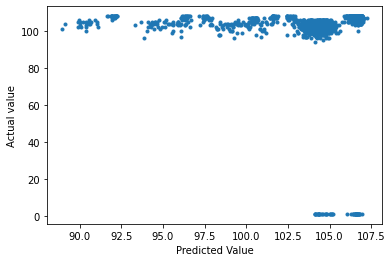

In [76]:
#main
tf.reset_default_graph()

# -*- coding: utf-8 -*-
"""
Created on Fri May 29 23:23:52 2020
@author: ChefLiutao
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#####################  hyper parameters  ####################
N_FEATURES = 6
A_LOW = 0
A_HIGH = 1
LR_A = 0.001
LR_C = 0.003
N_ACTOR_HIDDEN = 30
N_CRITIC_HIDDEN = 30
MAX_EPISODES = 4  #100
MAX_STEPS = 1000

GAMMA = 0.9                # 折扣因子
TAU = 0.1                 # 软更新因子
MEMORY_CAPACITY = 100000    #记忆库大小
BATCH_SIZE = 128            #批梯度下降的m
#############################################################

#Load data 
data = pd.read_csv('data1.csv',encoding = 'gbk') #Carga de datasets *********************************************
data = data.iloc[:,0]

#Build state matrix and best action
state,action = build_s_a(data,N_FEATURES,1)

#Data split
SPLIT_RATE = 0.75   #SIN WFV 75% PARA ENTRENAMIENTO Y 25% PARA TEST
split_index = round(len(state)*SPLIT_RATE)
train_s,train_a = state[:split_index],action[:split_index]
test_s,test_a = state[split_index:],action[split_index:]

#Normalization
train_s_scaled,test_s_scaled = normalization(train_s,test_s)
A,B = train_a.max(),train_a.min()
train_a_scaled,test_a_scaled = (train_a-B)/(A-B),(test_a-B)/(A-B)

# Training
ddpg = DDPG(N_FEATURES,A_LOW,A_HIGH,LR_A,LR_C,N_ACTOR_HIDDEN,N_CRITIC_HIDDEN)
for episode  in range(MAX_EPISODES):
    index = np.random.choice(range(len(train_s_scaled)))
    s = train_s_scaled[index]
    ep_reward = 0
    
    for step in range(MAX_STEPS):
        a = ddpg.choose_action(s)
        r = -abs(a-train_a_scaled[index])
        ep_reward += r
        index += 1
        s_ = train_s_scaled[index]
        
        ddpg.store_transition(s,a,r,s_)
        ddpg.learn()
        
        if (index == len(train_s_scaled)-1) or (step == MAX_STEPS-1):
            print('Episode %d : %.2f'%(episode,ep_reward))
            break
        
        s = s_

# Testing
pred = []
for i in range(len(test_s_scaled)):
    state = test_s_scaled[i]
    action = ddpg.choose_action(state)
    pred.append(action)

pred = [pred[i][0] for i in range(len(test_s_scaled))]
pred = pd.Series(pred)
pred = pred*(A-B)+B
actual = pd.Series(test_a)

plt.scatter(pred,test_a,marker = '.')
plt.xlabel('Predicted Value')
plt.ylabel('Actual value')
plt.show()

In [77]:
test_s_scaled[:,5]

array([0.95535714, 0.94642857, 0.9375    , ..., 0.91071429, 0.9375    ,
       0.90178571])

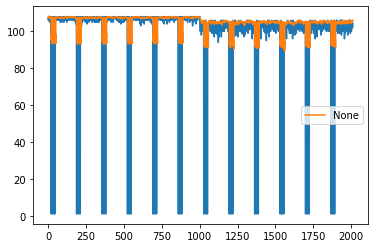

In [78]:
# Plot the forecast values 
plt.plot(test_a, label="real");
pred.plot(legend = True) ;

In [79]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate mean squared error 
mse = mean_squared_error(test_a, pred)
print("MSE: ")
print(mse)

# Calculate root mean squared error 
rmse = rmse(test_a, pred)
print("\nRMSE: ")
print(rmse)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape =  mean_absolute_percentage_error(test_a, pred)
print("\nMAPE (Porcentaje): ")
print(mape)

MSE: 
285.2496914163945

RMSE: 
16.889336618600343

MAPE (Porcentaje): 
254.00552022867262
